# DiffEdit

Image editing typically requires providing a mask of the area to be edited. DiffEdit automatically generates the mask for you based on a text query, making it easier overall to create a mask without image editing software. The DiffEdit algorithm works in three steps:

1. the diffusion model denoises an image conditioned on some query text and reference text which produces different noise estimates for different areas of the image; the difference is used to infer a mask to identify which area of the image needs to be changed to match the query text
2. the input image is encoded into latent space with DDIM
3. the latents are decoded with the diffusion model conditioned on the text query, using the mask as a guide such that pixels outside the mask remain the same as in the input image

This guide will show you how to use DiffEdit to edit images without manually creating a mask.

Before you begin, make sure you have the following libraries installed:

In [ ]:
# uncomment to install the necessary libraries in Colab
!pip install -q diffusers transformers accelerate

The [StableDiffusionDiffEditPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/diffedit#diffusers.StableDiffusionDiffEditPipeline) requires an image mask and a set of partially inverted latents. The image mask is generated from the [generate_mask()](https://huggingface.co/docs/diffusers/main/en/api/pipelines/diffedit#diffusers.StableDiffusionDiffEditPipeline.generate_mask) function, and includes two parameters, `source_prompt` and `target_prompt`. These parameters determine what to edit in the image. For example, if you want to change a bowl of *fruits* to a bowl of *pears*, then:

In [ ]:
source_prompt = "a black SUV"
target_prompt = "a black Sedan"

The partially inverted latents are generated from the [invert()](https://huggingface.co/docs/diffusers/main/en/api/pipelines/diffedit#diffusers.StableDiffusionDiffEditPipeline.invert) function, and it is generally a good idea to include a `prompt` or *caption* describing the image to help guide the inverse latent sampling process. The caption can often be your `source_prompt`, but feel free to experiment with other text descriptions!

Let's load the pipeline, scheduler, inverse scheduler, and enable some optimizations to reduce memory usage:

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline

pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The StableDiffusionDiffEditPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion_diffedit.pipeline_stable_diffusion_diffedit.StableDiffusionDiffEditPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration fi

Load the image to edit:

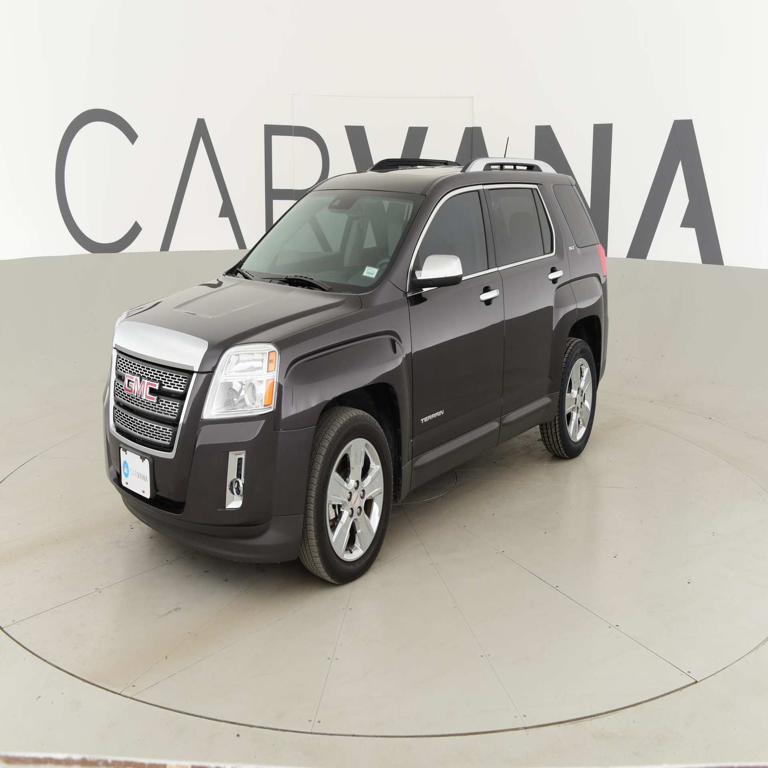

In [ ]:
from diffusers.utils import load_image, make_image_grid

img_path = "/content/original.png"
raw_image = load_image(img_path).resize((768, 768))
raw_image

Use the [generate_mask()](https://huggingface.co/docs/diffusers/main/en/api/pipelines/diffedit#diffusers.StableDiffusionDiffEditPipeline.generate_mask) function to generate the image mask. You'll need to pass it the `source_prompt` and `target_prompt` to specify what to edit in the image:

/tmp/ipython-input-2809287964.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))


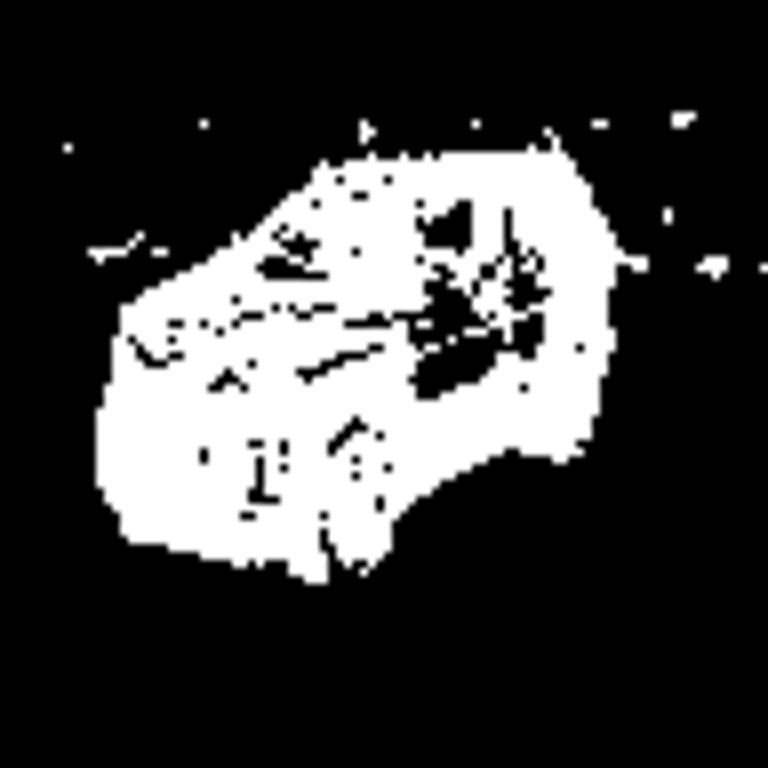

In [ ]:
from PIL import Image

source_prompt = "a black SUV"
target_prompt = "a black Sedan"
mask_image = pipeline.generate_mask(
    image=raw_image,
    source_prompt=source_prompt,
    target_prompt=target_prompt,
)
Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))

Next, create the inverted latents and pass it a caption describing the image:

In [ ]:
inv_latents = pipeline.invert(prompt=source_prompt, image=raw_image).latents

  0%|          | 0/40 [00:00<?, ?it/s]

Finally, pass the image mask and inverted latents to the pipeline. The `target_prompt` becomes the `prompt` now, and the `source_prompt` is used as the `negative_prompt`:

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-2353740295.py:7: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))


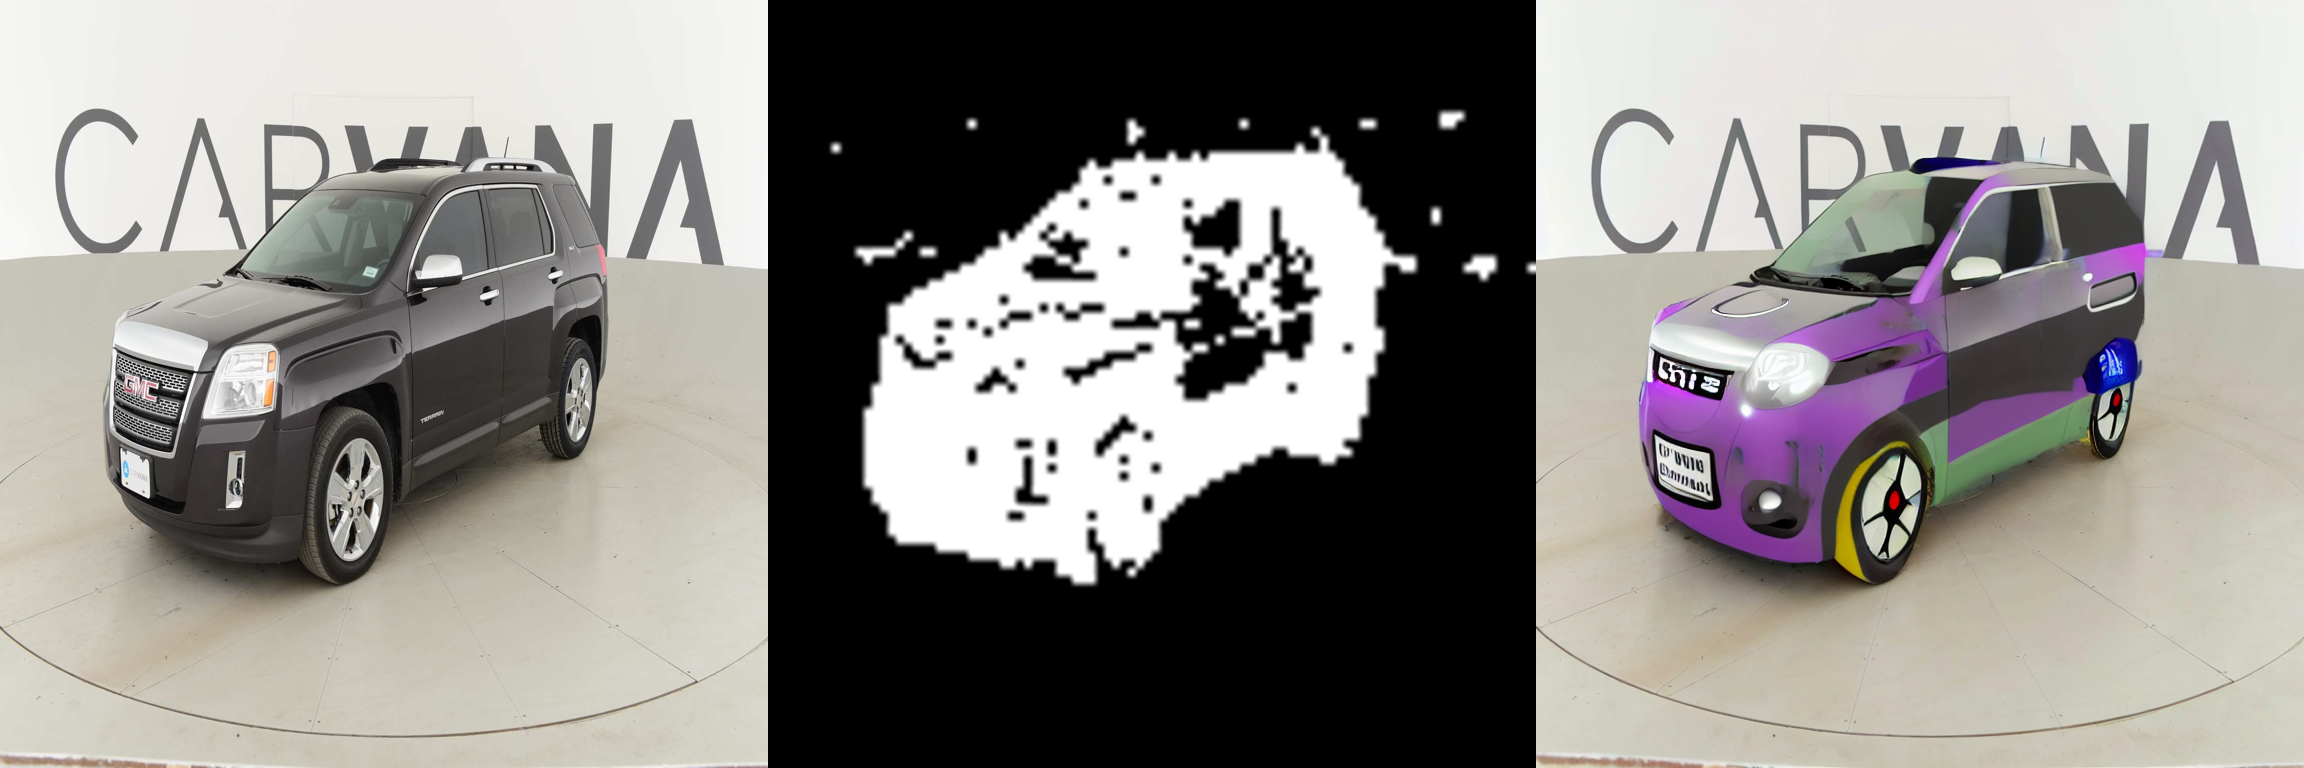

In [ ]:
output_image = pipeline(
    prompt=target_prompt,
    mask_image=mask_image,
    image_latents=inv_latents,
    negative_prompt=source_prompt,
).images[0]
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

## Generate source and target embeddings

The source and target embeddings can be automatically generated with the [Flan-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model instead of creating them manually.

Load the Flan-T5 model and tokenizer from the 🤗 Transformers library:

In [ ]:
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Provide some initial text to prompt the model to generate the source and target prompts.

In [ ]:
source_concept = "SUV"
target_concept = "Sedan"

source_text = f"Provide a caption for images containing a {source_concept}. "
"The captions should be in English and should be no longer than 150 characters."

target_text = f"Provide a caption for images containing a {target_concept}. "
"The captions should be in English and should be no longer than 150 characters."

'The captions should be in English and should be no longer than 150 characters.'

Next, create a utility function to generate the prompts:

In [ ]:
@torch.no_grad()
def generate_prompts(input_prompt):
    input_ids = tokenizer(input_prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(
        input_ids, temperature=0.8, num_return_sequences=16, do_sample=True, max_new_tokens=128, top_k=10
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

source_prompts = generate_prompts(source_text)
target_prompts = generate_prompts(target_text)
print(source_prompts)
print(target_prompts)

['A black SUV drives along the road', 'a man is seen driving a red SUV', 'This vehicle is parked outside of a building and is parked next to a parked SUV.', 'A woman in a red SUV is walking on the sidewalk.', "An SUV is seen parked in a lane at a city's airport.", 'A black vehicle is shown with a red and white vehicle next to it.', 'A black and white SUV parked on a parking lot.', 'a car driving in a highway', 'A red SUV on the highway', 'A man drives a red sports utility vehicle.', 'A man with a red and white car in an airport.', 'An SUV with its headlights off is in front of a police car.', 'The SUV is being parked on the curb outside.', 'a black SUV with a white stripe down the middle of it.', 'the vehicle is parked on the curb', 'A man preparing to stomp out his SUV in a snowy field.']
['A Sedan is a car with a hood, doors and tail lights.', 'A Sedan with a white roof and red interior.', 'a classic sedan with a rhodium-plated finish and chrome detailing', 'A tan sedan in the early 

> [!TIP]
> Check out the [generation strategy](https://huggingface.co/docs/transformers/main/en/generation_strategies) guide if you're interested in learning more about strategies for generating different quality text.

Load the text encoder model used by the [StableDiffusionDiffEditPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/diffedit#diffusers.StableDiffusionDiffEditPipeline) to encode the text. You'll use the text encoder to compute the text embeddings:

In [ ]:
import torch
from diffusers import StableDiffusionDiffEditPipeline

pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()

@torch.no_grad()
def embed_prompts(sentences, tokenizer, text_encoder, device="cuda"):
    embeddings = []
    for sent in sentences:
        text_inputs = tokenizer(
            sent,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=None)[0]
        embeddings.append(prompt_embeds)
    return torch.concatenate(embeddings, dim=0).mean(dim=0).unsqueeze(0)

source_embeds = embed_prompts(source_prompts, pipeline.tokenizer, pipeline.text_encoder)
target_embeds = embed_prompts(target_prompts, pipeline.tokenizer, pipeline.text_encoder)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The StableDiffusionDiffEditPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 


The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-707238796.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L")


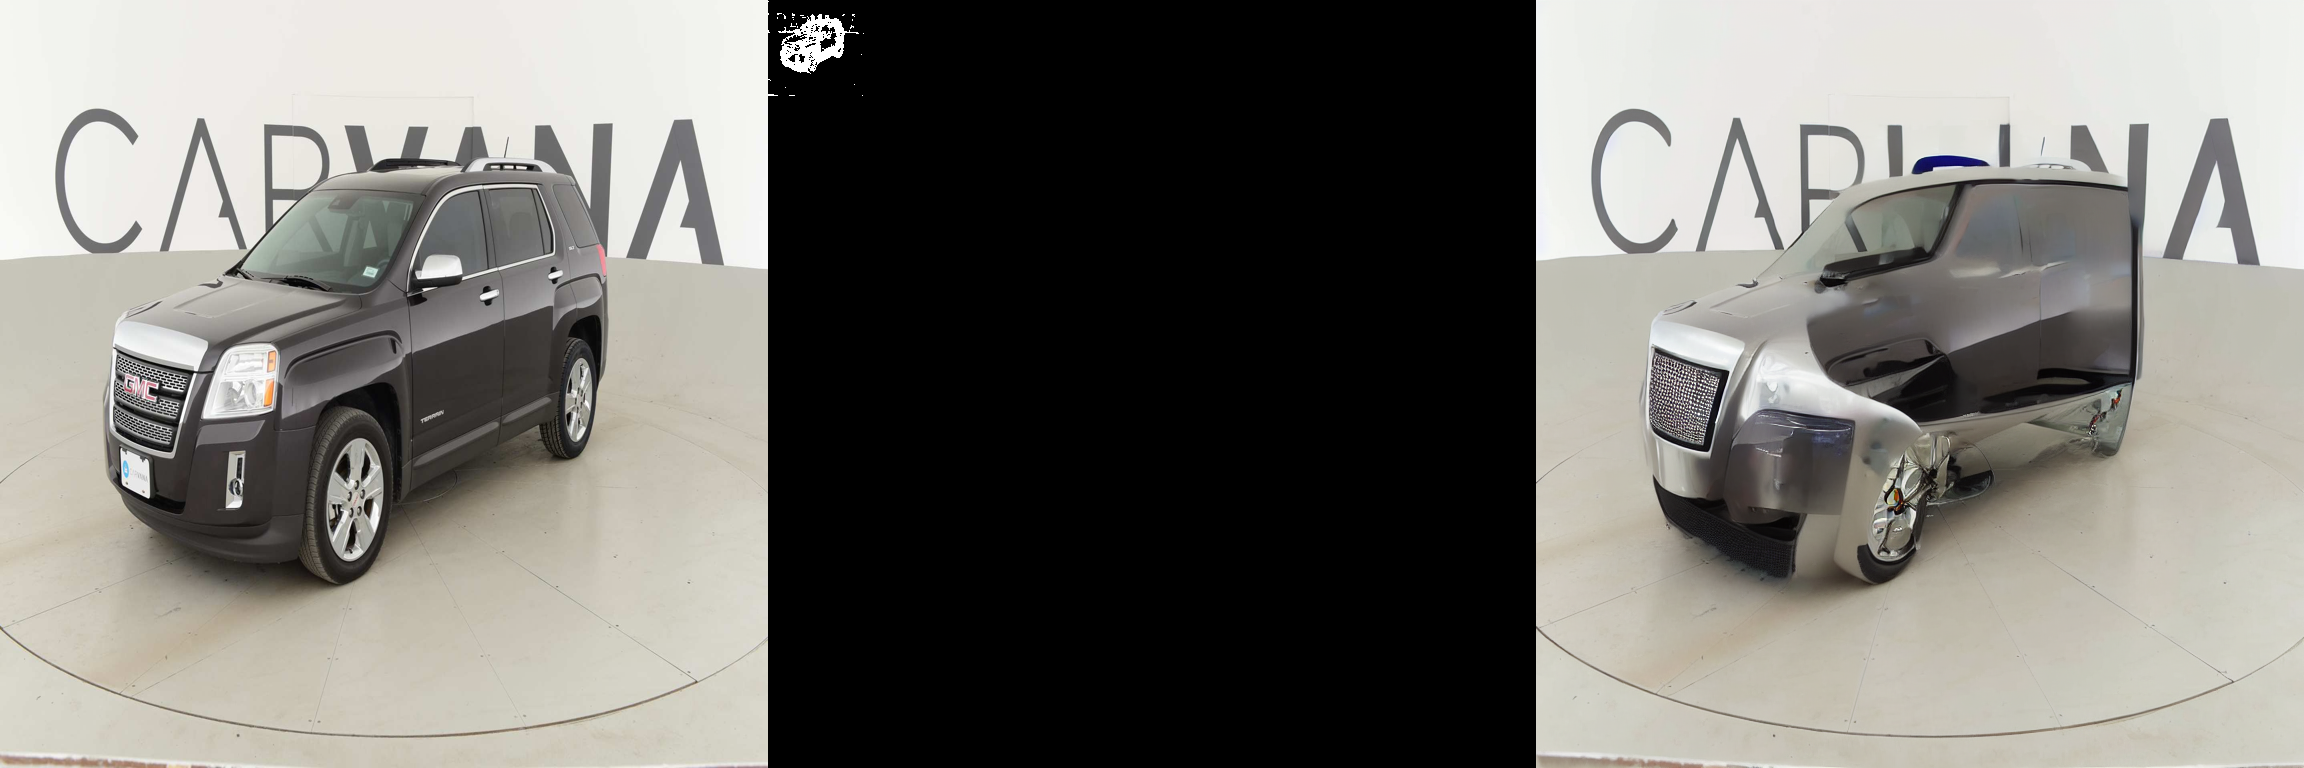

In [ ]:
from diffusers import DDIMInverseScheduler, DDIMScheduler
from diffusers.utils import load_image, make_image_grid
from PIL import Image

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)

img_path = "/content/original.png"
raw_image = load_image(img_path).resize((768, 768))

mask_image = pipeline.generate_mask(
    image=raw_image,
    source_prompt_embeds=source_embeds,
    target_prompt_embeds=target_embeds,
)

inv_latents = pipeline.invert(
    prompt_embeds=source_embeds,
    image=raw_image,
).latents

output_image = pipeline(
    mask_image=mask_image,
    image_latents=inv_latents,
    prompt_embeds=target_embeds,
    negative_prompt_embeds=source_embeds,
).images[0]
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L")
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

## Generate a caption for inversion

While you can use the `source_prompt` as a caption to help generate the partially inverted latents, you can also use the [BLIP](https://huggingface.co/docs/transformers/model_doc/blip) model to automatically generate a caption.

Load the BLIP model and processor from the 🤗 Transformers library:

In [ ]:
import torch
from transformers import BlipForConditionalGeneration, BlipProcessor

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16, low_cpu_mem_usage=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Create a utility function to generate a caption from the input image:

In [ ]:
@torch.no_grad()
def generate_caption(images, caption_generator, caption_processor):
    text = "a photograph of"

    inputs = caption_processor(images, text, return_tensors="pt").to(device="cuda", dtype=caption_generator.dtype)
    caption_generator.to("cuda")
    outputs = caption_generator.generate(**inputs, max_new_tokens=128)

    # offload caption generator
    caption_generator.to("cpu")

    caption = caption_processor.batch_decode(outputs, skip_special_tokens=True)[0]
    return caption

Load an input image and generate a caption for it using the `generate_caption` function:

In [ ]:
from diffusers.utils import load_image

img_path = "/content/original.png"
raw_image = load_image(img_path).resize((768, 768))
caption = generate_caption(raw_image, model, processor)


print(caption)

a photograph of a black and silver gmcv
